# Getting Started with Amazon SageMaker Automatic Model Tuning

## Background

Machine learning model training is controlled by the set of values that is refered to as hyperparameters. In contrast to parameters plugged into optimization functions, such as node weights or bias, hyperparameters are defined before model training. One can tune them manually to reach to better model performance by changing the values based on one's expertise. Alternatively, one can run hyperparameter optimization and tune these parameters automatically. 

Amazon SageMaker Automatic Model Tuning reduces the undifferentiated heavy lifting of researching the hyperparameter space, by launching training jobs with several sets of hyperparameter combinations and provides the set of best performing values as a result.

This tutorial will walk you through SageMaker Automatic Model Tuning (AMT) using a built-in XGBoost algorithm on Amazon SageMaker. Additional information can be found on documentation pages:
* For running a simple hyperparameter tuning job: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-ex.html
* For HyperParameterTuner API: https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html

## Overview

The notebook is split into the following sections:
* Setup and Imports
* Load and Prepare dataset
* Train a SageMaker Built-In XGBoost Algorithm
* Train and Tune a SageMaker Built-In XGBoost Algorithm
* View the AMT job statistics 
* Visualize AMT job results and tuned Hyperparameters


### Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
import sagemaker

#!{sys.executable} -m pip install --upgrade pip       --quiet # upgrade pip to the latest vesion
#!{sys.executable} -m pip install --upgrade sagemaker --quiet # upgrade SageMaker to the latest vesion
sagemaker.__version__

'2.88.1'

In [3]:
import io
import os
import argparse
import traceback
import boto3
import numpy as np
import pandas as pd

from sklearn import datasets
from pathlib import Path

In [4]:
# SDK setup
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
boto_sess = boto3.Session(region_name=region)
sm_sess = sagemaker.session.Session(boto_session=boto_sess, sagemaker_client=sm)

In [5]:
BUCKET = sm_sess.default_bucket()
PREFIX = 'amt-visualize-demo/data'
s3_data_url = f's3://{BUCKET}/{PREFIX}'

# Eventual output destination for our XGBoost model
output_path = f's3://{BUCKET}/{PREFIX}/output'
output_path

s3://sagemaker-eu-west-1-811243659808/amt-visualize-demo/data/output


## Load and Prepare dataset 

In [6]:
!mkdir -p data

The dataset used in the notebook is a scikit-learn library copy of the test set of the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits. Each datapoint is a 8x8 image of a digit. 

In [7]:
from sklearn import datasets

digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target
digits_df.insert(0, 'y', digits_df.pop('y')) # XGBoost expects the target to be the first column 

In [8]:
# Randomly sort the data then split out into train 70% and validation 30%
train_data, valid_data= np.split(
    digits_df, [int(0.7 * len(digits_df))]
)

In [9]:
train_data.to_csv("data/train.csv", index=False, header=False)
valid_data.to_csv("data/valid.csv", index=False, header=False) # valid

We upload train and validation datasets into Amazon S3. Amazon SageMaker will interact with the data directly from S3.

In [10]:
boto_sess.resource("s3").Bucket(BUCKET).Object(os.path.join(PREFIX, "train/train.csv")
                                                 ).upload_file("data/train.csv")
boto_sess.resource("s3").Bucket(BUCKET).Object(os.path.join(PREFIX, "valid/valid.csv")
                                                 ).upload_file("data/valid.csv")

We will use the built-in algorithm that comes in an image URI as described in the docs here:
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

## Train an Amazon SageMaker Built-In XGBoost Algorithm

In [11]:
%%time
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

hyperparameters = {
        "num_class": "10",
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"1",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"multi:softmax",
        "eval_metric":"accuracy",
        "num_round":"50"}

# lookup the XGBoost image URI and builds an XGBoost container
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.5-1")
display(xgboost_container)

# construct a SageMaker estimator that calls the XGBoost container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
s3_input_train = TrainingInput(
    s3_data=f's3://{BUCKET}/{PREFIX}/train', content_type="csv")
s3_input_valid = TrainingInput(
    s3_data=f's3://{BUCKET}/{PREFIX}/valid', content_type="csv")

# execute the XGBoost training job
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid})

'141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:1.5-1'

2022-10-19 16:02:13 Starting - Starting the training job...
2022-10-19 16:02:37 Starting - Preparing the instances for trainingProfilerReport-1666195333: InProgress
.........
2022-10-19 16:04:17 Downloading - Downloading input data....
2022-10-19 16:05:37 Training - Downloading the training image..[2022-10-19 16:05:50.658 ip-10-0-218-30.eu-west-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-19:16:05:50:INFO] Imported framework sagemaker_xgboost_container.training
[2022-10-19:16:05:50:INFO] Failed to parse hyperparameter eval_metric value accuracy to Json.
Returning the value itself
[2022-10-19:16:05:50:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2022-10-19:16:05:50:INFO] No GPUs detected (normal if no gpus installed)
[2022-10-19:16:05:50:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-10-19:16:05:50:INFO] Determined delimiter of CSV input is ','
[2022-10-19:16:05:50:INFO] Determined

## Train and Tune an Amazon SageMaker Built-In XGBoost Algorithm

Amazon SageMaker AMT now orchestrates different trials. We use `tuner.wait()` to pause notebook execution until the AMT job is completed. Depending on the number of jobs and teh configuration of their paralelization this may take a while. For the example above it may take around 10 minutes. During this time you can view the status of your jobs in the console by navigating to Amazon SageMaker > Training > Hyperparameter tuning jobs.

For more information on AMT job monitoring, see: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-monitor.html

In [12]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

n_jobs = 50
n_parallel_jobs = 2

# redundant declaration - included for visibility 
hyperparameters = {
        "num_class": "10",
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"1",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"multi:softmax",
        "eval_metric":"accuracy",
        "num_round":"50"}

hpt_ranges = {'eta': IntegerParameter(0, 1),
              'alpha': IntegerParameter(0, 2),
              'min_child_weight': IntegerParameter(1, 10),
              'max_depth': IntegerParameter(1, 20)
             }

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'bayesian',                   
                    'objective_metric_name': 'validation:accuracy',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Bayesian',
                    'max_jobs': n_jobs,
                    'max_parallel_jobs': n_parallel_jobs}

In [13]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_input_train, 'validation': s3_input_valid}, wait=False)
tuner_name = tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {tuner_name}.')

tuning job submitted: bayesian-221019-1807.


In [14]:
tuner.wait()

...............................................................................................!


## View the AMT job statistics and results 

Tuning jobs you have run can be accessed from the Amazon SageMaker console at https://console.aws.amazon.com/sagemaker/. Select Hyperparameter tuning job from the Training menu to see the list. More information here: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-monitor.html

We can check the results of the HPO jobs and investigate the hyperparameters used, the final value achieved in the objective function and the total training time per job.

#### This can be done either via the Amazon SageMaker Python SDK

In [15]:
sagemaker.HyperparameterTuningJobAnalytics(tuner_name).dataframe()[:10]

,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.0,1.0,17.0,2.0,bayesian-221019-1807-005-10cec4fd,Completed,0.85370,2022-10-19 18:12:41+02:00,2022-10-19 18:14:44+02:00,123.0
1,1.0,0.0,7.0,9.0,bayesian-221019-1807-004-15837acc,Completed,0.09815,2022-10-19 18:11:36+02:00,2022-10-19 18:12:38+02:00,62.0
2,2.0,0.0,10.0,3.0,bayesian-221019-1807-003-1775dbe2,Completed,0.09815,2022-10-19 18:11:23+02:00,2022-10-19 18:12:30+02:00,67.0
3,1.0,0.0,16.0,4.0,bayesian-221019-1807-002-abfa6dd4,Completed,0.09815,2022-10-19 18:08:54+02:00,2022-10-19 18:11:26+02:00,152.0
4,0.0,1.0,3.0,9.0,bayesian-221019-1807-001-39fac05e,Completed,0.84815,2022-10-19 18:08:43+02:00,2022-10-19 18:11:06+02:00,143.0


#### Or via the AWS SDK for Python (Boto3)

With the boto3 client we review the results of HPO job using describe_hyper_parameter_tuning_job() function.

In [16]:
#sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_name)   # to review all statistics
sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_name)['BestTrainingJob']

{'TrainingJobName': 'bayesian-221019-1807-005-10cec4fd',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:811243659808:training-job/bayesian-221019-1807-005-10cec4fd',
 'CreationTime': datetime.datetime(2022, 10, 19, 18, 12, 36, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 10, 19, 18, 12, 41, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 10, 19, 18, 14, 44, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'alpha': '0',
  'eta': '1',
  'max_depth': '17',
  'min_child_weight': '2'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
  'Value': 0.8536999821662903},
 'ObjectiveStatus': 'Succeeded'}

We can also utilize the boto3 list_training_jobs_for_hyper_parameter_tuning_job() function to review the results sorted by the value of the objective function and including metric definitions. More functions available for Amazon SageMaker with boto3 are described on this page: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html

In [17]:
hpo_jobs = sm.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_name,
    MaxResults=100,
    SortBy='FinalObjectiveMetricValue',
    SortOrder='Descending')

for job in hpo_jobs['TrainingJobSummaries'][:10]:
    job_descr = sm.describe_training_job(TrainingJobName=job['TrainingJobName'])
    metrics = {m['MetricName']:  m['Value'] for m in job_descr['FinalMetricDataList']}
    print(f'{job["TrainingJobName"]} Metrics: {metrics}')

bayesian-221019-1807-005-10cec4fd Metrics: {'train:mlogloss': 0.03440999984741211, 'train:accuracy': 1.0, 'validation:accuracy': 0.8536999821662903, 'validation:mlogloss': 0.5714799761772156, 'ObjectiveMetric': 0.8536999821662903}
bayesian-221019-1807-001-39fac05e Metrics: {'train:mlogloss': 0.07757999747991562, 'train:accuracy': 0.988070011138916, 'validation:accuracy': 0.8481500148773193, 'validation:mlogloss': 0.520110011100769, 'ObjectiveMetric': 0.8481500148773193}
bayesian-221019-1807-003-1775dbe2 Metrics: {'train:mlogloss': 2.3025999069213867, 'train:accuracy': 0.09944000095129013, 'validation:accuracy': 0.09814999997615814, 'validation:mlogloss': 2.3025898933410645, 'ObjectiveMetric': 0.09814999997615814}
bayesian-221019-1807-004-15837acc Metrics: {'train:mlogloss': 2.3025999069213867, 'train:accuracy': 0.09944000095129013, 'validation:accuracy': 0.09814999997615814, 'validation:mlogloss': 2.3025898933410645, 'ObjectiveMetric': 0.09814999997615814}
bayesian-221019-1807-002-abfa

## Visualize AMT job results and tuned Hyperparameters

Finally, we want to visualise the behaviour of our hyperparameters at different values.

To do this, we are using the altair library, and have written two custom analysis scripts `job_analytics.py` and `reporting_util.py` that we make available with this notebook

In [20]:
!pip install -Uq pip altair

Please ensure that the role used by SageMaker allows the cloudwatch:ListMetrics action on IAM.

Tuning job bayesian-221019-1807      status: Completed

Number of training jobs with valid objective: 5
Lowest: 0.09814999997615814 Highest 0.8536999821662903


,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,validation:accuracy
0,0.0,1.0,17.0,2.0,bayesian-221019-1807-005-10cec4fd,Completed,2022-10-19 18:12:41+02:00,2022-10-19 18:14:44+02:00,123.0,bayesian-221019-1807,0.85370
4,0.0,1.0,3.0,9.0,bayesian-221019-1807-001-39fac05e,Completed,2022-10-19 18:08:43+02:00,2022-10-19 18:11:06+02:00,143.0,bayesian-221019-1807,0.84815
1,1.0,0.0,7.0,9.0,bayesian-221019-1807-004-15837acc,Completed,2022-10-19 18:11:36+02:00,2022-10-19 18:12:38+02:00,62.0,bayesian-221019-1807,0.09815
2,2.0,0.0,10.0,3.0,bayesian-221019-1807-003-1775dbe2,Completed,2022-10-19 18:11:23+02:00,2022-10-19 18:12:30+02:00,67.0,bayesian-221019-1807,0.09815
3,1.0,0.0,16.0,4.0,bayesian-221019-1807-002-abfa6dd4,Completed,2022-10-19 18:08:54+02:00,2022-10-19 18:11:26+02:00,152.0,bayesian-221019-1807,0.09815


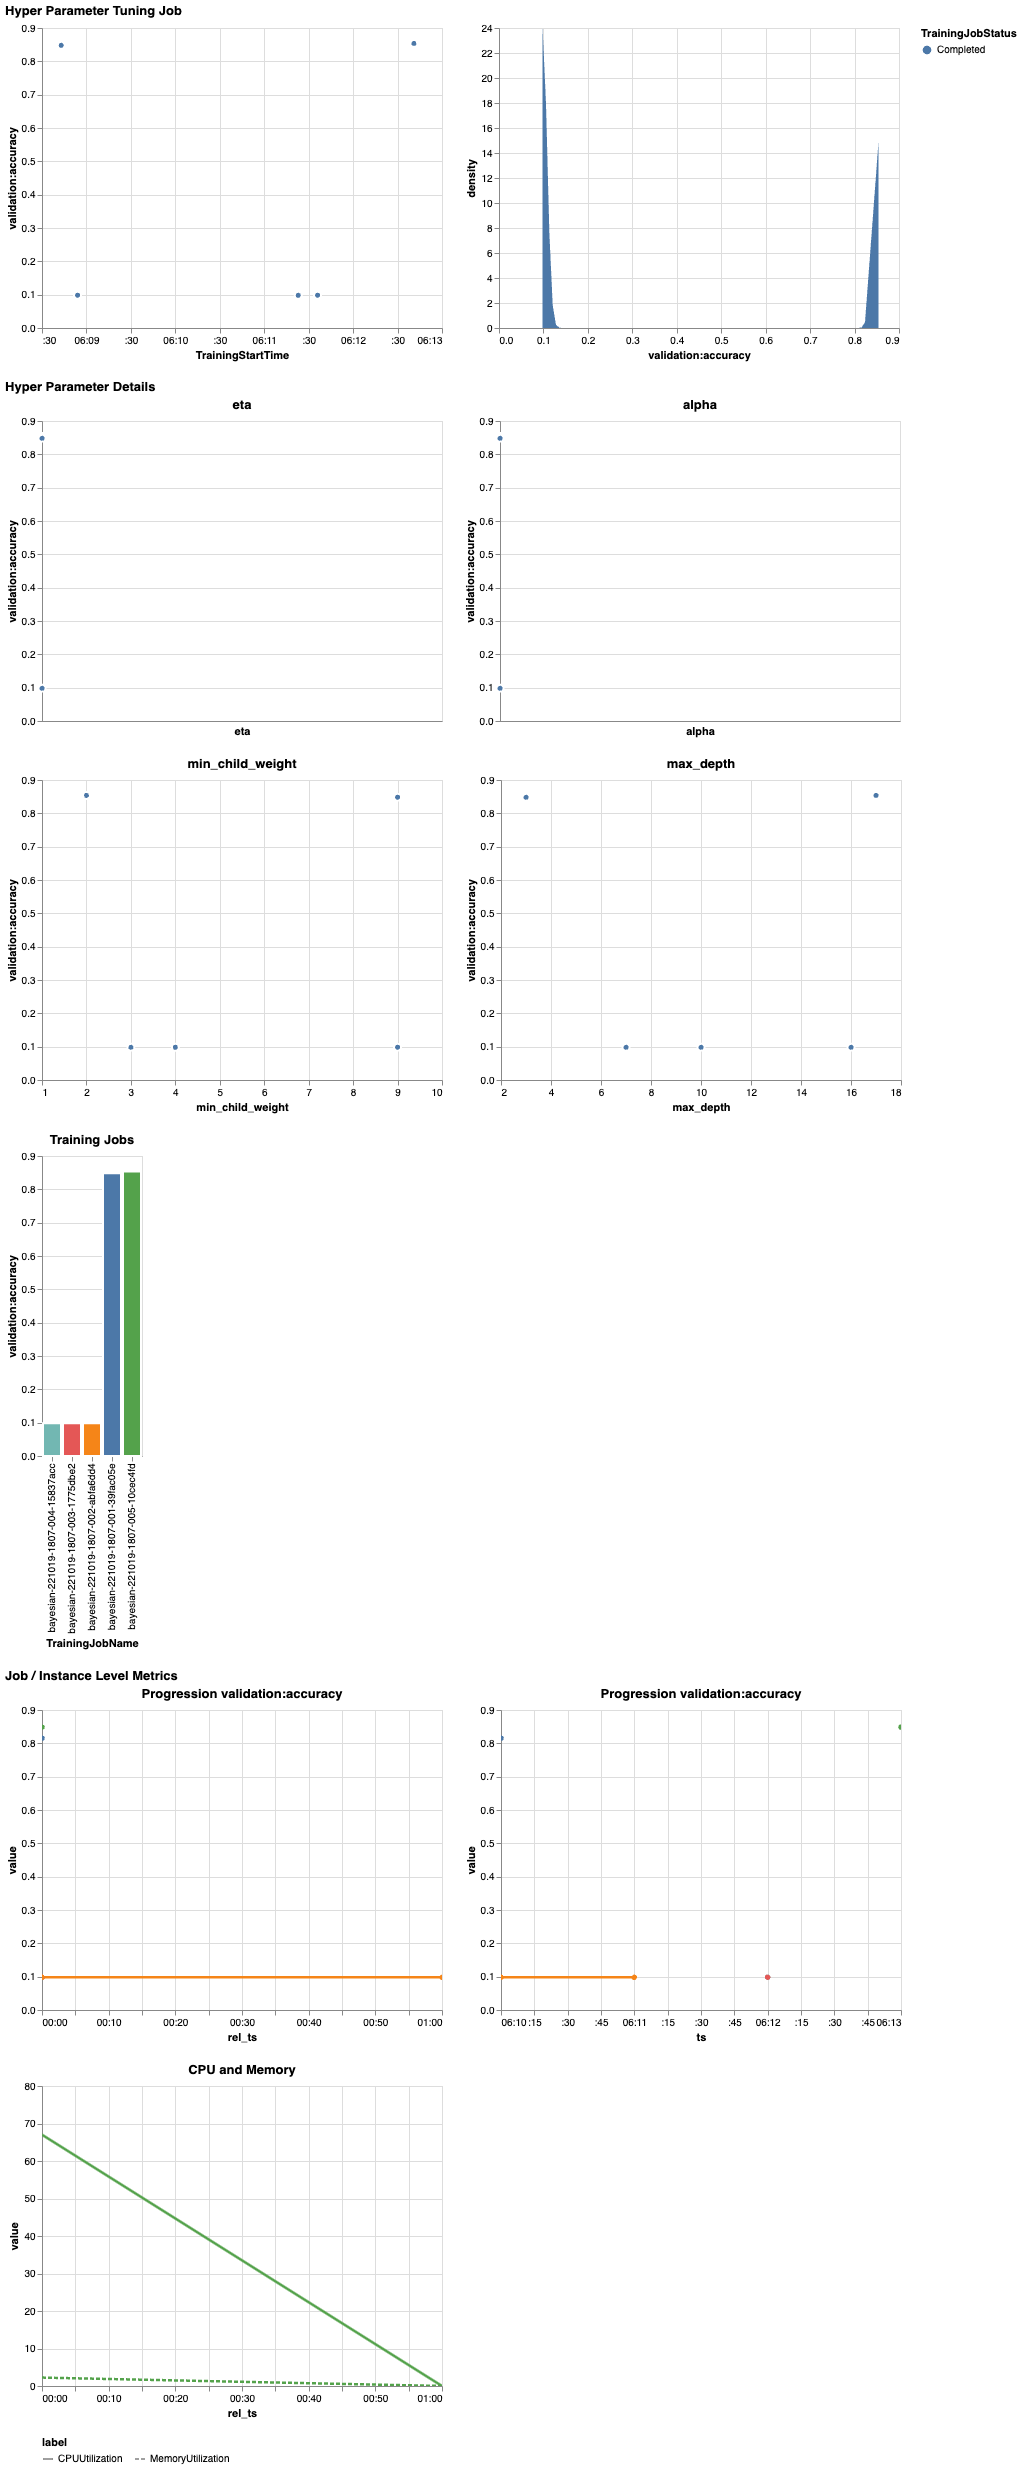

In [19]:
from reporting_util import analyze_hpo_job
analyze_hpo_job(tuner)